# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pr2_utils
import time
import matplotlib.pyplot as plt
#%matplotlib qt
import numpy as np
from scipy.special import softmax
import pickle

# Access Processed Sensor Data

In [2]:
with open('lidar_sync.npy', 'rb') as f:
    lidar_sync = np.load(f)
#print(lidar_sync)

In [3]:
with open('final_x.npy', 'rb') as f:
    a = np.load(f)
#print(a)

In [4]:
with open('final_y.npy', 'rb') as f:
    b = np.load(f)
#print(b)

In [5]:
positions=np.stack((a,b))

In [6]:
with open('cumulativeYaw_sync.npy', 'rb') as f:
    cumulativeYaw_sync= np.load(f)
#print(cumulativeYaw_sync.shape)

In [7]:
with open('lidar2VehicleDict.p', 'rb') as fp:
    lidar2VehicleDict = pickle.load(fp)

In [8]:
with open('yaw_sync.npy', 'rb') as f:
    yaw_sync = np.load(f)
    
with open('final_v.npy', 'rb') as f:
    v = np.load(f)
    
print(yaw_sync.shape)
print(v.shape)

(115865, 2)
(115865,)


In [9]:
with open('encoder_sync.npy', 'rb') as f:
    encoder_sync = np.load(f)
print(encoder_sync)

[[1.54458265e+18 0.00000000e+00 0.00000000e+00]
 [1.54458265e+18 9.60000000e+01 9.60000000e+01]
 [1.54458265e+18 9.60000000e+01 9.60000000e+01]
 ...
 [1.54458381e+18 1.43000000e+02 1.43000000e+02]
 [1.54458381e+18 1.44000000e+02 1.44000000e+02]
 [1.54458381e+18 1.42000000e+02 1.42000000e+02]]


In [10]:
left_wheel_diam=0.623479
right_wheel_diam=0.622806
d=(left_wheel_diam+right_wheel_diam)/2

# Initialize Grid Cells

size x: 1401
size y: 1401


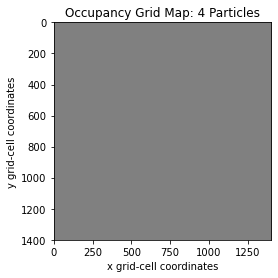

In [11]:
MAP = {}
MAP['res']   = 1 #meters
MAP['xmin']  = -100  #meters
MAP['ymin']  = -1200
MAP['xmax']  =  1300
MAP['ymax']  =  200
MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
print("size x:", MAP['sizex'])
print("size y:", MAP['sizey'])
MAP['map'] = 128*np.ones((MAP['sizex'],MAP['sizey'],3), dtype=np.int32) #DATA TYPE: char or int8
plt.title("Occupancy Grid Map: 4 Particles")
plt.xlabel("x grid-cell coordinates")
plt.ylabel("y grid-cell coordinates")

x_im = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']) #x-positions of each pixel of the map
y_im = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res']) #y-positions of each pixel of the map

x_range = np.arange(-0.4,0.4+0.1,0.1)
y_range = np.arange(-0.4,0.4+0.1,0.1)


plt.imshow(MAP['map'])
plt.pause(0.01)
plt.show()
trajectory=np.array([np.zeros(2)])


# Particle Filter Hyper Parameters

In [12]:
numParticles=4
alphas=np.ones(numParticles)/numParticles
print(alphas)
u=np.zeros([3,numParticles])
grid_side_size=1401


[0.25 0.25 0.25 0.25]


# Define Map and Log Odds

In [ ]:
lambda_t=np.zeros((grid_side_size,grid_side_size))
m=np.zeros((grid_side_size,grid_side_size))
m[(lambda_t<=0)] = 0
m[(lambda_t>0)] = 1
absoluteRange=15*np.log(4)

# Noise

In [13]:
mean=np.array([0,0])

In [14]:
v_variance=np.var(v)
yaw_variance=np.var(yaw_sync[:,1])

cov=np.block([
    [v_variance/50,               0],
    [0, yaw_variance/5000]
    ])

In [15]:
noise_sample=np.random.multivariate_normal(mean, cov)
print(noise_sample)

[ 4.71672853e-01 -3.96739224e-06]


# Particle Prediction

In [16]:
def predict(timeStep): #input is timestep, i>1, respect the pipeline of always indexing i, not i-1

    tau= (lidar_sync[timeStep,0]-lidar_sync[timeStep-1,0])*(1e-9)
    v_t= np.pi*(d)*((encoder_sync[timeStep,1]+encoder_sync[timeStep,2])/2)/(4096*tau)

    linear_velocity= v_t #standard
    theta_t=yaw_sync[timeStep,1]
    for i in range (numParticles):
     
        noisy_angular= theta_t+np.random.normal(0, np.abs(theta_t/50))
        #noisy_angular= theta_t
        u[2,i]= u[2,i]+noisy_angular
        noise_linear=  linear_velocity + np.random.normal(0, np.abs(linear_velocity/200))
        #noise_linear=  linear_velocity
        differential=np.array([noise_linear*np.cos(u[2,i]), noise_linear*np.sin(u[2,i])])
        differential=np.hstack((differential, np.zeros(1)))
        u[:,i]=u[:,i]+tau*differential
       # print("tau:" ,tau, ",v_t:", v_t, "yaw:", theta_t, "position", "=", u[[0,1],i])

# World to Grid Function

In [17]:
def filter(matrix):
    xs0= matrix[0,:]
    ys0= matrix[1,:]
    xis = np.ceil((xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int32)-1
    yis = np.ceil((ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int32)-1

    # build an arbitrary map 
    indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))
    return np.vstack((xis,yis))

# Resample Function

In [18]:
def resample():
    #print(u)
    global alphas
    global u
    uIndices=np.random.choice(u.shape[1], u.shape[1], p=alphas)
    newSampling=u[:,uIndices]
    u=newSampling
    alphas=np.ones(u.shape[1])/(u.shape[1])

# Log Odds and Mapping Function

In [19]:
def mapping_and_logOdds(bestGridPosition, bestGridLidar):
    global lambda_t
    for j in range(bestGridLidar.shape[1]):
        bresOutput=pr2_utils.bresenham2D(bestGridPosition[0],bestGridPosition[1],bestGridLidar[0,j],bestGridLidar[1,j]).astype(np.int32)
        numColumns=bresOutput.shape[1]
        MAP['map'][bresOutput[0,:],bresOutput[1,:],:] = np.array([255,255,255])
        MAP['map'][bresOutput[0,-1],bresOutput[1,-1],:] = np.array([0,0,0])
        lambda_t[bresOutput[0,np.arange(numColumns-2)],bresOutput[1,np.arange(numColumns-2)]]= lambda_t[bresOutput[0,np.arange(numColumns-2)],bresOutput[1,np.arange(numColumns-2)]]-np.log(4)
        lambda_t[bresOutput[0,-1],bresOutput[1,-1]]= lambda_t[bresOutput[0,-1],bresOutput[1,-1]]+np.log(4)

# Update Function

In [20]:
def update_and_mapping(timeStep):
    global m
    global lambda_t
    global trajectory
    global world_particles

    ph=np.zeros(numParticles)
    correlationArray=np.zeros(numParticles)
    
    # World to FOG pose transformation matrix
    W_T_S= np.block([
    [np.eye(3),               np.array([0.335,0.035, -0.78]).reshape(3,1)],
    [np.zeros((1, 3)), 1               ]
    ])
        
    for i in range(numParticles):
        cumulativeYaw_t=u[2,i] #after selecting particle, get its R and P
        R=np.array([[np.cos(cumulativeYaw_t), -np.sin(cumulativeYaw_t),0 ],[np.sin(cumulativeYaw_t), np.cos(cumulativeYaw_t),0 ],[0,0,1]])
        P= np.array([u[0,i],u[1,i],0]).reshape(3,1)

        S_T_V= np.block([
        [R,               P],
        [np.zeros((1, 3)), 1               ]
        ])

        worldLidarMatrix_i=W_T_S@S_T_V@lidar2VehicleDict[str(timeStep+1)]    
        c=pr2_utils.mapCorrelation(m,x_im,y_im,worldLidarMatrix_i[[0,1],:],x_range,y_range)
        correlationArray[i] = np.max(c) #max correlation of particle i

    ph= softmax((correlationArray-np.max(correlationArray))) #softmax all correlations


    #determine alphas
    particlesWeightsBuffer=np.zeros(numParticles)
    for i in range(numParticles):
        particlesWeightsBuffer[i]=alphas[i]*ph[i]
    
    for i in range(numParticles):
        alphas[i]= particlesWeightsBuffer[i]/np.sum(particlesWeightsBuffer)
        
    highestParticleIndex= np.argmax(alphas)    
    nextPosition=np.array([[u[0,highestParticleIndex],u[1,highestParticleIndex]]])
    trajectory=np.concatenate((trajectory,nextPosition), axis=0)
    
    #project scan from best particle
    cumulativeYaw_t=u[2,highestParticleIndex] #after selecting particle, get its R and P
    R=np.array([[np.cos(cumulativeYaw_t), -np.sin(cumulativeYaw_t),0 ],[np.sin(cumulativeYaw_t), np.cos(cumulativeYaw_t),0 ],[0,0,1]])
    P= np.array([u[0,highestParticleIndex],u[1,highestParticleIndex],0]).reshape(3,1)

    S_T_V= np.block([
    [R,               P],
    [np.zeros((1, 3)), 1]
    ])
        
    worldLidarMatrix=W_T_S@S_T_V@lidar2VehicleDict[str(timeStep+1)]
    initial_point_x= np.ceil((u[0,highestParticleIndex] - MAP['xmin']) / MAP['res'] ).astype(np.int32)-1
    initial_point_y = np.ceil((u[1,highestParticleIndex] - MAP['ymin']) / MAP['res'] ).astype(np.int32)-1
    cells_worldLidarMatrix=filter(worldLidarMatrix)

    #update map and log odds
    mapping_and_logOdds(np.array([initial_point_x,initial_point_y]), cells_worldLidarMatrix) # feed in list that corresponds to be particle
    
    #binarize lambda
    m[(lambda_t>0)] = 1
    m[(lambda_t<=0)] = 0
    
    #cap lambda
    lambda_t[(lambda_t>=absoluteRange)] = absoluteRange
    lambda_t[(lambda_t<=-absoluteRange)] = -absoluteRange
    
    #n_threshold and n_eff
    n_eff=1/np.linalg.norm(alphas)**2

    #threshold depending on number of particles, change depending on situation
    if(n_eff<0.4*numParticles):
        print("resampled at iteration:", timeStep)
        resample()



# SLAM Particle Filter: Main 

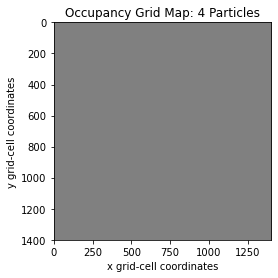

In [21]:
plt.title("Occupancy Grid Map: 4 Particles")
plt.xlabel("x grid-cell coordinates")
plt.ylabel("y grid-cell coordinates")
plt.imshow(MAP['map'])
plt.pause(0.01)
plt.show()

resampled at iteration: 240
resampled at iteration: 420
resampled at iteration: 660
resampled at iteration: 870
resampled at iteration: 1210
resampled at iteration: 1370
resampled at iteration: 1610
resampled at iteration: 2020
resampled at iteration: 2110
resampled at iteration: 2250
resampled at iteration: 2360
resampled at iteration: 2630
resampled at iteration: 3210
resampled at iteration: 9770
resampled at iteration: 16900
resampled at iteration: 17150
resampled at iteration: 17460
resampled at iteration: 17740
resampled at iteration: 17890
resampled at iteration: 17990
resampled at iteration: 18180
resampled at iteration: 18440
resampled at iteration: 18700
resampled at iteration: 18910
resampled at iteration: 19670
resampled at iteration: 19820
resampled at iteration: 19880
resampled at iteration: 20300
resampled at iteration: 20740
resampled at iteration: 20910
resampled at iteration: 21400
resampled at iteration: 21660
resampled at iteration: 21770
resampled at iteration: 2196

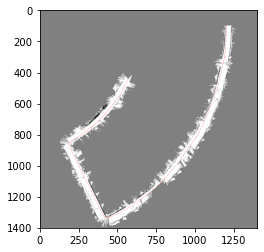

Slam Output at Iteration: 50000
resampled at iteration: 50070
resampled at iteration: 50240
resampled at iteration: 50430
resampled at iteration: 50480
resampled at iteration: 50910
resampled at iteration: 51130
resampled at iteration: 51460
resampled at iteration: 51840
resampled at iteration: 55910
resampled at iteration: 56090
resampled at iteration: 56280
resampled at iteration: 56480
resampled at iteration: 56990
resampled at iteration: 57640
resampled at iteration: 57900
resampled at iteration: 58240
resampled at iteration: 58560
resampled at iteration: 61390
resampled at iteration: 62040
resampled at iteration: 62440
resampled at iteration: 62810
resampled at iteration: 62840
resampled at iteration: 63080
resampled at iteration: 63260
resampled at iteration: 63590
resampled at iteration: 63910
resampled at iteration: 64410
resampled at iteration: 64570
resampled at iteration: 64880
resampled at iteration: 65490
resampled at iteration: 66020
resampled at iteration: 66280
resample

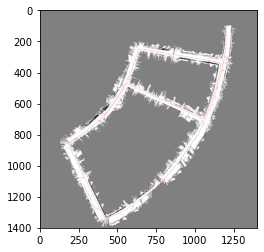

Slam Output at Iteration: 100000
resampled at iteration: 104960
resampled at iteration: 105170
resampled at iteration: 105240
resampled at iteration: 105430
resampled at iteration: 105510
resampled at iteration: 105670
resampled at iteration: 105910
resampled at iteration: 105950
resampled at iteration: 106200
resampled at iteration: 106730
resampled at iteration: 106800
resampled at iteration: 107240
resampled at iteration: 107380
resampled at iteration: 108620
resampled at iteration: 110580
resampled at iteration: 111160
resampled at iteration: 111650
resampled at iteration: 111730
resampled at iteration: 112110
resampled at iteration: 112210
resampled at iteration: 112620
resampled at iteration: 112890
resampled at iteration: 113140
resampled at iteration: 113370
resampled at iteration: 113440
resampled at iteration: 113500
resampled at iteration: 113620
resampled at iteration: 113950
resampled at iteration: 114420
resampled at iteration: 114830
resampled at iteration: 115030
resamp

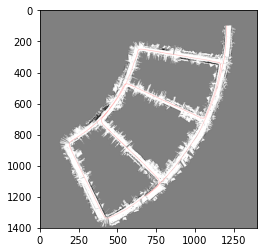

iter 115864


In [22]:
for i in range(1,115865):
    predict(i)
    
    if(i%10==0):
        update_and_mapping(i)
        
    if(i%50000==0): #display map, no map correlation needed
        cell_trajectory= filter(np.transpose(trajectory))
        MAP['map'][cell_trajectory[0,:],cell_trajectory[1,:]] = np.array([255,0,0])
        plt.imshow(MAP['map'])
        plt.pause(0.01)
        print("Slam Output at Iteration:", i)
        plt.show()
        
cell_trajectory= filter(np.transpose(trajectory))
MAP['map'][cell_trajectory[0,:],cell_trajectory[1,:]] = np.array([255,0,0])
plt.imshow(MAP['map'])
plt.pause(0.01)
print("iter", i)
plt.show()


In [23]:
np.sum(lambda_t)

-4572508.959298292

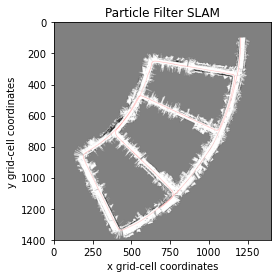

In [24]:
plt.title("Particle Filter SLAM")
plt.xlabel("x grid-cell coordinates")
plt.ylabel("y grid-cell coordinates")

plt.imshow(MAP['map'])
plt.pause(0.01)
plt.show()

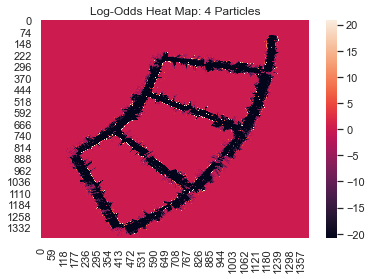

In [31]:
import seaborn as sns; sns.set_theme()

plt.title("Log-Odds Heat Map: 4 Particles")
plt.xlabel("x grid-cell coordinates")
plt.ylabel("y grid-cell coordinates")

import numpy as np; 
import seaborn as sns; sns.set_theme()
ax = sns.heatmap(lambda_t)



# 